<h1 align="center">TensorFlow Neural Network Lab</h1>

<img src="image/notmnist.png">
In this lab, you'll use all the tools you learned from *Introduction to TensorFlow* to label images of English letters! The data you are using, <a href="http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html">notMNIST</a>, consists of images of a letter from A to J in differents font.

The above images are a few examples of the data you'll be training on. After training the network, you will compare your prediction model against test data. Your goal, by the end of this lab, is to make predictions against that test set with at least an 80% accuracy. Let's jump in!

To start this lab, you first need to import all the necessary modules. Run the code below. If it runs successfully, it will print "`All modules imported`".

In [1]:
import hashlib
import os
import pickle
from urllib.request import urlretrieve

import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile

print('All modules imported.')

All modules imported.


The notMNIST dataset is too large for many computers to handle.  It contains 500,000 images for just training.  You'll be using a subset of this data, 15,000 images for each label (A-J).

In [2]:
def download(url, file):
    """
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    """
    if not os.path.isfile(file):
        print('Downloading ' + file + '...')
        urlretrieve(url, file)
        print('Download Finished')

# Download the training and test dataset.
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_train.zip', 'notMNIST_train.zip')
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_test.zip', 'notMNIST_test.zip')

# Make sure the files aren't corrupted
assert hashlib.md5(open('notMNIST_train.zip', 'rb').read()).hexdigest() == 'c8673b3f28f489e9cdf3a3d74e2ac8fa',\
        'notMNIST_train.zip file is corrupted.  Remove the file and try again.'
assert hashlib.md5(open('notMNIST_test.zip', 'rb').read()).hexdigest() == '5d3c7e653e63471c88df796156a9dfa9',\
        'notMNIST_test.zip file is corrupted.  Remove the file and try again.'

# Wait until you see that all files have been downloaded.
print('All files downloaded.')

Download Finished


Download Finished


All files downloaded.


In [3]:
def uncompress_features_labels(file):
    """
    Uncompress features and labels from a zip file
    :param file: The zip file to extract the data from
    """
    features = []
    labels = []

    with ZipFile(file) as zipf:
        # Progress Bar
        filenames_pbar = tqdm(zipf.namelist(), unit='files')
        
        # Get features and labels from all files
        for filename in filenames_pbar:
            # Check if the file is a directory
            if not filename.endswith('/'):
                with zipf.open(filename) as image_file:
                    image = Image.open(image_file)
                    image.load()
                    # Load image data as 1 dimensional array
                    # We're using float32 to save on memory space
                    feature = np.array(image, dtype=np.float32).flatten()

                # Get the the letter from the filename.  This is the letter of the image.
                label = os.path.split(filename)[1][0]

                features.append(feature)
                labels.append(label)
    return np.array(features), np.array(labels)

# Get the features and labels from the zip files
train_features, train_labels = uncompress_features_labels('notMNIST_train.zip')
test_features, test_labels = uncompress_features_labels('notMNIST_test.zip')

# Limit the amount of data to work with a docker container
docker_size_limit = 150000
train_features, train_labels = resample(train_features, train_labels, n_samples=docker_size_limit)

# Set flags for feature engineering.  This will prevent you from skipping an important step.
is_features_normal = False
is_labels_encod = False

# Wait until you see that all features and labels have been uncompressed.
print('All features and labels uncompressed.')

  0%|          | 0/210001 [00:00<?, ?files/s]

  0%|          | 428/210001 [00:00<00:49, 4276.32files/s]

  0%|          | 965/210001 [00:00<00:45, 4552.72files/s]

  1%|          | 1513/210001 [00:00<00:43, 4794.50files/s]

  1%|          | 2035/210001 [00:00<00:42, 4914.03files/s]

  1%|          | 2502/210001 [00:00<00:42, 4833.91files/s]

  1%|▏         | 3013/210001 [00:00<00:42, 4911.84files/s]

  2%|▏         | 3471/210001 [00:00<00:42, 4807.06files/s]

  2%|▏         | 4034/210001 [00:00<00:40, 5023.66files/s]

  2%|▏         | 4623/210001 [00:00<00:39, 5252.12files/s]

  2%|▏         | 5164/210001 [00:01<00:38, 5297.89files/s]

  3%|▎         | 5753/210001 [00:01<00:37, 5458.48files/s]

  3%|▎         | 6314/210001 [00:01<00:37, 5499.21files/s]

  3%|▎         | 6895/210001 [00:01<00:36, 5587.37files/s]

  4%|▎         | 7453/210001 [00:01<00:36, 5577.56files/s]

  4%|▍         | 8032/210001 [00:01<00:35, 5638.48files/s]

  4%|▍         | 8636/210001 [00:01<00:35, 5750.99files/s]

  4%|▍         | 9212/210001 [00:01<00:34, 5741.92files/s]

  5%|▍         | 9787/210001 [00:01<00:35, 5613.15files/s]

  5%|▍         | 10349/210001 [00:01<00:38, 5140.84files/s]

  5%|▌         | 10916/210001 [00:02<00:37, 5288.12files/s]

  5%|▌         | 11519/210001 [00:02<00:36, 5486.67files/s]

  6%|▌         | 12075/210001 [00:02<00:36, 5424.48files/s]

  6%|▌         | 12623/210001 [00:02<00:36, 5364.87files/s]

  6%|▋         | 13194/210001 [00:02<00:36, 5462.84files/s]

  7%|▋         | 13786/210001 [00:02<00:35, 5589.06files/s]

  7%|▋         | 14348/210001 [00:02<00:37, 5206.90files/s]

  7%|▋         | 14905/210001 [00:02<00:36, 5309.62files/s]

  7%|▋         | 15480/210001 [00:02<00:35, 5433.01files/s]

  8%|▊         | 16060/210001 [00:02<00:35, 5537.04files/s]

  8%|▊         | 16633/210001 [00:03<00:34, 5588.32files/s]

  8%|▊         | 17216/210001 [00:03<00:34, 5658.30files/s]

  8%|▊         | 17784/210001 [00:03<00:33, 5654.53files/s]

  9%|▊         | 18351/210001 [00:03<00:35, 5438.79files/s]

  9%|▉         | 18898/210001 [00:03<00:38, 5010.75files/s]

  9%|▉         | 19453/210001 [00:03<00:36, 5159.90files/s]

 10%|▉         | 19989/210001 [00:03<00:36, 5213.39files/s]

 10%|▉         | 20516/210001 [00:03<00:38, 4885.26files/s]

 10%|█         | 21069/210001 [00:03<00:37, 5062.22files/s]

 10%|█         | 21647/210001 [00:04<00:35, 5252.48files/s]

 11%|█         | 22180/210001 [00:04<00:37, 4999.34files/s]

 11%|█         | 22688/210001 [00:04<00:37, 4979.31files/s]

 11%|█         | 23192/210001 [00:04<00:37, 4919.58files/s]

 11%|█▏        | 23718/210001 [00:04<00:37, 5010.53files/s]

 12%|█▏        | 24223/210001 [00:04<00:39, 4681.30files/s]

 12%|█▏        | 24732/210001 [00:04<00:38, 4795.10files/s]

 12%|█▏        | 25226/210001 [00:04<00:38, 4827.83files/s]

 12%|█▏        | 25713/210001 [00:04<00:42, 4352.15files/s]

 12%|█▏        | 26160/210001 [00:05<00:44, 4146.32files/s]

 13%|█▎        | 26651/210001 [00:05<00:42, 4348.61files/s]

 13%|█▎        | 27096/210001 [00:05<00:44, 4096.95files/s]

 13%|█▎        | 27598/210001 [00:05<00:42, 4334.77files/s]

 13%|█▎        | 28142/210001 [00:05<00:39, 4615.54files/s]

 14%|█▎        | 28709/210001 [00:05<00:37, 4884.86files/s]

 14%|█▍        | 29270/210001 [00:05<00:35, 5078.28files/s]

 14%|█▍        | 29863/210001 [00:05<00:33, 5305.01files/s]

 14%|█▍        | 30404/210001 [00:05<00:36, 4959.90files/s]

 15%|█▍        | 30912/210001 [00:06<00:38, 4616.57files/s]

 15%|█▍        | 31442/210001 [00:06<00:37, 4802.34files/s]

 15%|█▌        | 31993/210001 [00:06<00:35, 4994.74files/s]

 15%|█▌        | 32503/210001 [00:06<00:35, 5017.55files/s]

 16%|█▌        | 33012/210001 [00:06<00:43, 4093.24files/s]

 16%|█▌        | 33492/210001 [00:06<00:41, 4282.13files/s]

 16%|█▌        | 34043/210001 [00:06<00:38, 4588.54files/s]

 16%|█▋        | 34562/210001 [00:06<00:36, 4749.95files/s]

 17%|█▋        | 35056/210001 [00:06<00:36, 4731.04files/s]

 17%|█▋        | 35542/210001 [00:07<00:36, 4740.37files/s]

 17%|█▋        | 36120/210001 [00:07<00:34, 5009.04files/s]

 17%|█▋        | 36709/210001 [00:07<00:33, 5243.51files/s]

 18%|█▊        | 37292/210001 [00:07<00:31, 5402.88files/s]

 18%|█▊        | 37885/210001 [00:07<00:31, 5548.24files/s]

 18%|█▊        | 38482/210001 [00:07<00:30, 5667.37files/s]

 19%|█▊        | 39074/210001 [00:07<00:29, 5737.51files/s]

 19%|█▉        | 39660/210001 [00:07<00:29, 5771.44files/s]

 19%|█▉        | 40246/210001 [00:07<00:29, 5796.61files/s]

 19%|█▉        | 40830/210001 [00:07<00:29, 5807.21files/s]

 20%|█▉        | 41423/210001 [00:08<00:28, 5840.36files/s]

 20%|██        | 42009/210001 [00:08<00:30, 5592.85files/s]

 20%|██        | 42572/210001 [00:08<00:30, 5572.23files/s]

 21%|██        | 43132/210001 [00:08<00:30, 5406.08files/s]

 21%|██        | 43690/210001 [00:08<00:30, 5455.65files/s]

 21%|██        | 44238/210001 [00:08<00:30, 5354.61files/s]

 21%|██▏       | 44799/210001 [00:08<00:30, 5427.30files/s]

 22%|██▏       | 45353/210001 [00:08<00:30, 5457.39files/s]

 22%|██▏       | 45900/210001 [00:08<00:32, 5118.79files/s]

 22%|██▏       | 46423/210001 [00:08<00:31, 5150.24files/s]

 22%|██▏       | 46998/210001 [00:09<00:30, 5315.28files/s]

 23%|██▎       | 47568/210001 [00:09<00:29, 5424.35files/s]

 23%|██▎       | 48114/210001 [00:09<00:32, 4989.76files/s]

 23%|██▎       | 48663/210001 [00:09<00:31, 5128.29files/s]

 23%|██▎       | 49256/210001 [00:09<00:30, 5340.98files/s]

 24%|██▎       | 49798/210001 [00:09<00:30, 5334.05files/s]

 24%|██▍       | 50337/210001 [00:09<00:31, 4997.19files/s]

 24%|██▍       | 50862/210001 [00:09<00:31, 5068.79files/s]

 25%|██▍       | 51461/210001 [00:09<00:29, 5309.48files/s]

 25%|██▍       | 52013/210001 [00:10<00:29, 5361.18files/s]

 25%|██▌       | 52555/210001 [00:10<00:31, 5044.13files/s]

 25%|██▌       | 53108/210001 [00:10<00:30, 5178.78files/s]

 26%|██▌       | 53702/210001 [00:10<00:29, 5384.59files/s]

 26%|██▌       | 54284/210001 [00:10<00:28, 5506.01files/s]

 26%|██▌       | 54840/210001 [00:10<00:31, 4977.58files/s]

 26%|██▋       | 55352/210001 [00:10<00:32, 4716.24files/s]

 27%|██▋       | 55891/210001 [00:10<00:31, 4898.44files/s]

 27%|██▋       | 56439/210001 [00:10<00:30, 5059.22files/s]

 27%|██▋       | 56954/210001 [00:11<00:34, 4398.41files/s]

 27%|██▋       | 57515/210001 [00:11<00:32, 4703.09files/s]

 28%|██▊       | 58081/210001 [00:11<00:30, 4946.01files/s]

 28%|██▊       | 58594/210001 [00:11<00:32, 4681.71files/s]

 28%|██▊       | 59176/210001 [00:11<00:30, 4972.97files/s]

 28%|██▊       | 59764/210001 [00:11<00:28, 5212.15files/s]

 29%|██▊       | 60300/210001 [00:11<00:30, 4839.51files/s]

 29%|██▉       | 60846/210001 [00:11<00:29, 5009.17files/s]

 29%|██▉       | 61398/210001 [00:11<00:28, 5148.84files/s]

 30%|██▉       | 61953/210001 [00:12<00:28, 5262.79files/s]

 30%|██▉       | 62487/210001 [00:12<00:29, 5086.43files/s]

 30%|███       | 63045/210001 [00:12<00:28, 5223.87files/s]

 30%|███       | 63609/210001 [00:12<00:27, 5338.42files/s]

 31%|███       | 64148/210001 [00:12<00:31, 4677.23files/s]

 31%|███       | 64691/210001 [00:12<00:29, 4879.28files/s]

 31%|███       | 65261/210001 [00:12<00:28, 5098.33files/s]

 31%|███▏      | 65824/210001 [00:12<00:27, 5245.04files/s]

 32%|███▏      | 66359/210001 [00:12<00:28, 5019.04files/s]

 32%|███▏      | 66916/210001 [00:13<00:27, 5171.46files/s]

 32%|███▏      | 67468/210001 [00:13<00:27, 5269.33files/s]

 32%|███▏      | 68001/210001 [00:13<00:27, 5184.67files/s]

 33%|███▎      | 68524/210001 [00:13<00:27, 5164.69files/s]

 33%|███▎      | 69084/210001 [00:13<00:26, 5286.88files/s]

 33%|███▎      | 69642/210001 [00:13<00:26, 5368.30files/s]

 33%|███▎      | 70230/210001 [00:13<00:25, 5509.31files/s]

 34%|███▎      | 70821/210001 [00:13<00:24, 5620.90files/s]

 34%|███▍      | 71423/210001 [00:13<00:24, 5731.24files/s]

 34%|███▍      | 72009/210001 [00:13<00:23, 5767.48files/s]

 35%|███▍      | 72608/210001 [00:14<00:23, 5830.94files/s]

 35%|███▍      | 73194/210001 [00:14<00:23, 5838.18files/s]

 35%|███▌      | 73779/210001 [00:14<00:25, 5391.90files/s]

 35%|███▌      | 74346/210001 [00:14<00:24, 5472.27files/s]

 36%|███▌      | 74899/210001 [00:14<00:24, 5460.47files/s]

 36%|███▌      | 75466/210001 [00:14<00:24, 5521.20files/s]

 36%|███▌      | 76021/210001 [00:14<00:24, 5516.76files/s]

 36%|███▋      | 76579/210001 [00:14<00:24, 5534.54files/s]

 37%|███▋      | 77134/210001 [00:14<00:24, 5432.73files/s]

 37%|███▋      | 77684/210001 [00:14<00:24, 5451.99files/s]

 37%|███▋      | 78241/210001 [00:15<00:24, 5485.03files/s]

 38%|███▊      | 78814/210001 [00:15<00:23, 5554.91files/s]

 38%|███▊      | 79400/210001 [00:15<00:23, 5637.06files/s]

 38%|███▊      | 79969/210001 [00:15<00:23, 5650.21files/s]

 38%|███▊      | 80535/210001 [00:15<00:22, 5645.46files/s]

 39%|███▊      | 81100/210001 [00:15<00:24, 5343.08files/s]

 39%|███▉      | 81638/210001 [00:15<00:25, 5086.49files/s]

 39%|███▉      | 82205/210001 [00:15<00:24, 5247.50files/s]

 39%|███▉      | 82763/210001 [00:15<00:23, 5341.32files/s]

 40%|███▉      | 83301/210001 [00:16<00:25, 4896.72files/s]

 40%|███▉      | 83860/210001 [00:16<00:24, 5084.67files/s]

 40%|████      | 84378/210001 [00:16<00:26, 4741.25files/s]

 40%|████      | 84933/210001 [00:16<00:25, 4956.26files/s]

 41%|████      | 85452/210001 [00:16<00:24, 5024.13files/s]

 41%|████      | 85976/210001 [00:16<00:24, 5084.58files/s]

 41%|████      | 86516/210001 [00:16<00:23, 5172.96files/s]

 41%|████▏     | 87038/210001 [00:16<00:25, 4909.63files/s]

 42%|████▏     | 87552/210001 [00:16<00:24, 4975.61files/s]

 42%|████▏     | 88113/210001 [00:16<00:23, 5146.60files/s]

 42%|████▏     | 88678/210001 [00:17<00:22, 5284.20files/s]

 42%|████▏     | 89211/210001 [00:17<00:22, 5266.17files/s]

 43%|████▎     | 89759/210001 [00:17<00:22, 5328.51files/s]

 43%|████▎     | 90294/210001 [00:17<00:25, 4725.98files/s]

 43%|████▎     | 90781/210001 [00:17<00:25, 4586.01files/s]

 43%|████▎     | 91262/210001 [00:17<00:25, 4650.82files/s]

 44%|████▎     | 91809/210001 [00:17<00:24, 4866.75files/s]

 44%|████▍     | 92304/210001 [00:17<00:24, 4807.18files/s]

 44%|████▍     | 92791/210001 [00:17<00:25, 4630.09files/s]

 44%|████▍     | 93299/210001 [00:18<00:24, 4756.45files/s]

 45%|████▍     | 93835/210001 [00:18<00:23, 4919.99files/s]

 45%|████▍     | 94332/210001 [00:18<00:24, 4703.70files/s]

 45%|████▌     | 94810/210001 [00:18<00:24, 4722.48files/s]

 45%|████▌     | 95286/210001 [00:18<00:25, 4433.85files/s]

 46%|████▌     | 95736/210001 [00:18<00:27, 4118.59files/s]

 46%|████▌     | 96369/210001 [00:18<00:24, 4599.64files/s]

 46%|████▌     | 97013/210001 [00:18<00:22, 5027.17files/s]

 47%|████▋     | 97658/210001 [00:18<00:20, 5382.94files/s]

 47%|████▋     | 98294/210001 [00:19<00:19, 5642.35files/s]

 47%|████▋     | 98932/210001 [00:19<00:19, 5844.21files/s]

 47%|████▋     | 99578/210001 [00:19<00:18, 6011.68files/s]

 48%|████▊     | 100215/210001 [00:19<00:17, 6113.63files/s]

 48%|████▊     | 100852/210001 [00:19<00:17, 6180.74files/s]

 48%|████▊     | 101478/210001 [00:19<00:17, 6179.79files/s]

 49%|████▊     | 102101/210001 [00:19<00:17, 6152.39files/s]

 49%|████▉     | 102730/210001 [00:19<00:17, 6190.50files/s]

 49%|████▉     | 103364/210001 [00:19<00:17, 6230.87files/s]

 50%|████▉     | 103989/210001 [00:19<00:17, 6217.72files/s]

 50%|████▉     | 104632/210001 [00:20<00:16, 6277.87files/s]

 50%|█████     | 105270/210001 [00:20<00:16, 6304.91files/s]

 50%|█████     | 105914/210001 [00:20<00:16, 6343.43files/s]

 51%|█████     | 106558/210001 [00:20<00:16, 6366.61files/s]

 51%|█████     | 107197/210001 [00:20<00:16, 6371.15files/s]

 51%|█████▏    | 107847/210001 [00:20<00:15, 6408.09files/s]

 52%|█████▏    | 108489/210001 [00:20<00:15, 6402.72files/s]

 52%|█████▏    | 109130/210001 [00:20<00:15, 6378.54files/s]

 52%|█████▏    | 109769/210001 [00:20<00:15, 6338.38files/s]

 53%|█████▎    | 110404/210001 [00:20<00:15, 6329.01files/s]

 53%|█████▎    | 111049/210001 [00:21<00:15, 6362.39files/s]

 53%|█████▎    | 111696/210001 [00:21<00:15, 6393.95files/s]

 53%|█████▎    | 112339/210001 [00:21<00:15, 6399.61files/s]

 54%|█████▍    | 112994/210001 [00:21<00:15, 6441.59files/s]

 54%|█████▍    | 113639/210001 [00:21<00:15, 6398.10files/s]

 54%|█████▍    | 114279/210001 [00:21<00:15, 6335.16files/s]

 55%|█████▍    | 114919/210001 [00:21<00:14, 6354.38files/s]

 55%|█████▌    | 115555/210001 [00:21<00:14, 6305.61files/s]

 55%|█████▌    | 116186/210001 [00:21<00:14, 6278.57files/s]

 56%|█████▌    | 116823/210001 [00:21<00:14, 6304.27files/s]

 56%|█████▌    | 117465/210001 [00:22<00:14, 6332.61files/s]

 56%|█████▌    | 118111/210001 [00:22<00:14, 6367.12files/s]

 57%|█████▋    | 118748/210001 [00:22<00:14, 6356.32files/s]

 57%|█████▋    | 119403/210001 [00:22<00:14, 6410.82files/s]

 57%|█████▋    | 120049/210001 [00:22<00:14, 6420.11files/s]

 57%|█████▋    | 120692/210001 [00:22<00:13, 6405.81files/s]

 58%|█████▊    | 121333/210001 [00:22<00:13, 6379.94files/s]

 58%|█████▊    | 121972/210001 [00:22<00:13, 6324.30files/s]

 58%|█████▊    | 122605/210001 [00:22<00:13, 6313.37files/s]

 59%|█████▊    | 123237/210001 [00:22<00:13, 6315.35files/s]

 59%|█████▉    | 123881/210001 [00:23<00:13, 6349.49files/s]

 59%|█████▉    | 124538/210001 [00:23<00:13, 6413.90files/s]

 60%|█████▉    | 125183/210001 [00:23<00:13, 6423.33files/s]

 60%|█████▉    | 125828/210001 [00:23<00:13, 6431.21files/s]

 60%|██████    | 126472/210001 [00:23<00:13, 6335.93files/s]

 61%|██████    | 127106/210001 [00:23<00:13, 6280.04files/s]

 61%|██████    | 127735/210001 [00:23<00:13, 6251.15files/s]

 61%|██████    | 128361/210001 [00:23<00:13, 6205.79files/s]

 61%|██████▏   | 128986/210001 [00:23<00:13, 6218.92files/s]

 62%|██████▏   | 129619/210001 [00:23<00:12, 6246.00files/s]

 62%|██████▏   | 130255/210001 [00:24<00:12, 6277.21files/s]

 62%|██████▏   | 130898/210001 [00:24<00:12, 6318.94files/s]

 63%|██████▎   | 131540/210001 [00:24<00:12, 6347.34files/s]

 63%|██████▎   | 132189/210001 [00:24<00:12, 6384.76files/s]

 63%|██████▎   | 132834/210001 [00:24<00:12, 6402.34files/s]

 64%|██████▎   | 133475/210001 [00:24<00:11, 6402.62files/s]

 64%|██████▍   | 134122/210001 [00:24<00:11, 6422.08files/s]

 64%|██████▍   | 134765/210001 [00:24<00:11, 6408.81files/s]

 64%|██████▍   | 135406/210001 [00:24<00:12, 6094.81files/s]

 65%|██████▍   | 136020/210001 [00:24<00:12, 6105.92files/s]

 65%|██████▌   | 136633/210001 [00:25<00:12, 6083.96files/s]

 65%|██████▌   | 137259/210001 [00:25<00:11, 6132.92files/s]

 66%|██████▌   | 137892/210001 [00:25<00:11, 6189.82files/s]

 66%|██████▌   | 138530/210001 [00:25<00:11, 6238.40files/s]

 66%|██████▋   | 139168/210001 [00:25<00:11, 6278.03files/s]

 67%|██████▋   | 139803/210001 [00:25<00:11, 6297.29files/s]

 67%|██████▋   | 140434/210001 [00:25<00:11, 6216.95files/s]

 67%|██████▋   | 141057/210001 [00:25<00:16, 4150.82files/s]

 67%|██████▋   | 141563/210001 [00:26<00:18, 3688.53files/s]

 68%|██████▊   | 142005/210001 [00:26<00:24, 2824.66files/s]

 68%|██████▊   | 142370/210001 [00:26<00:24, 2811.16files/s]

 68%|██████▊   | 142915/210001 [00:26<00:20, 3288.02files/s]

 68%|██████▊   | 143415/210001 [00:26<00:18, 3663.04files/s]

 68%|██████▊   | 143847/210001 [00:26<00:17, 3837.72files/s]

 69%|██████▉   | 144419/210001 [00:26<00:15, 4256.92files/s]

 69%|██████▉   | 144962/210001 [00:26<00:14, 4550.29files/s]

 69%|██████▉   | 145538/210001 [00:27<00:13, 4855.87files/s]

 70%|██████▉   | 146115/210001 [00:27<00:12, 5092.55files/s]

 70%|██████▉   | 146705/210001 [00:27<00:11, 5309.70files/s]

 70%|███████   | 147257/210001 [00:27<00:12, 5227.98files/s]

 70%|███████   | 147795/210001 [00:27<00:12, 5131.65files/s]

 71%|███████   | 148364/210001 [00:27<00:11, 5287.02files/s]

 71%|███████   | 148972/210001 [00:27<00:11, 5501.95files/s]

 71%|███████   | 149531/210001 [00:27<00:11, 5187.97files/s]

 71%|███████▏  | 150060/210001 [00:27<00:11, 5105.83files/s]

 72%|███████▏  | 150632/210001 [00:28<00:11, 5274.96files/s]

 72%|███████▏  | 151199/210001 [00:28<00:10, 5383.06files/s]

 72%|███████▏  | 151743/210001 [00:28<00:11, 5196.86files/s]

 73%|███████▎  | 152268/210001 [00:28<00:11, 5146.03files/s]

 73%|███████▎  | 152818/210001 [00:28<00:10, 5246.28files/s]

 73%|███████▎  | 153347/210001 [00:28<00:10, 5258.63files/s]

 73%|███████▎  | 153898/210001 [00:28<00:10, 5326.09files/s]

 74%|███████▎  | 154443/210001 [00:28<00:10, 5360.12files/s]

 74%|███████▍  | 155011/210001 [00:28<00:10, 5451.98files/s]

 74%|███████▍  | 155566/210001 [00:28<00:09, 5480.70files/s]

 74%|███████▍  | 156116/210001 [00:29<00:09, 5485.53files/s]

 75%|███████▍  | 156666/210001 [00:29<00:09, 5457.56files/s]

 75%|███████▍  | 157213/210001 [00:29<00:11, 4729.38files/s]

 75%|███████▌  | 157704/210001 [00:29<00:13, 4013.26files/s]

 75%|███████▌  | 158137/210001 [00:29<00:12, 4102.36files/s]

 76%|███████▌  | 158626/210001 [00:29<00:11, 4309.88files/s]

 76%|███████▌  | 159187/210001 [00:29<00:10, 4631.82files/s]

 76%|███████▌  | 159742/210001 [00:29<00:10, 4872.65files/s]

 76%|███████▋  | 160317/210001 [00:29<00:09, 5104.75files/s]

 77%|███████▋  | 160881/210001 [00:30<00:09, 5251.61files/s]

 77%|███████▋  | 161444/210001 [00:30<00:09, 5358.20files/s]

 77%|███████▋  | 162024/210001 [00:30<00:08, 5478.25files/s]

 77%|███████▋  | 162629/210001 [00:30<00:08, 5637.57files/s]

 78%|███████▊  | 163230/210001 [00:30<00:08, 5740.43files/s]

 78%|███████▊  | 163833/210001 [00:30<00:07, 5822.97files/s]

 78%|███████▊  | 164430/210001 [00:30<00:07, 5862.89files/s]

 79%|███████▊  | 165019/210001 [00:30<00:07, 5869.59files/s]

 79%|███████▉  | 165616/210001 [00:30<00:07, 5897.31files/s]

 79%|███████▉  | 166223/210001 [00:30<00:07, 5944.47files/s]

 79%|███████▉  | 166828/210001 [00:31<00:07, 5973.13files/s]

 80%|███████▉  | 167427/210001 [00:31<00:07, 5931.30files/s]

 80%|████████  | 168028/210001 [00:31<00:07, 5954.11files/s]

 80%|████████  | 168629/210001 [00:31<00:06, 5968.71files/s]

 81%|████████  | 169260/210001 [00:31<00:06, 6010.23files/s]

 81%|████████  | 169873/210001 [00:31<00:06, 6044.18files/s]

 81%|████████  | 170500/210001 [00:31<00:06, 6109.53files/s]

 81%|████████▏ | 171119/210001 [00:31<00:06, 6127.88files/s]

 82%|████████▏ | 171733/210001 [00:31<00:06, 6124.84files/s]

 82%|████████▏ | 172346/210001 [00:31<00:06, 6108.93files/s]

 82%|████████▏ | 172958/210001 [00:32<00:06, 6071.76files/s]

 83%|████████▎ | 173566/210001 [00:32<00:06, 6044.63files/s]

 83%|████████▎ | 174171/210001 [00:32<00:05, 6032.78files/s]

 83%|████████▎ | 174785/210001 [00:32<00:05, 6062.22files/s]

 84%|████████▎ | 175416/210001 [00:32<00:05, 6132.75files/s]

 84%|████████▍ | 176031/210001 [00:32<00:05, 6133.06files/s]

 84%|████████▍ | 176645/210001 [00:32<00:05, 6103.67files/s]

 84%|████████▍ | 177256/210001 [00:32<00:05, 6076.51files/s]

 85%|████████▍ | 177864/210001 [00:32<00:05, 6067.12files/s]

 85%|████████▍ | 178477/210001 [00:33<00:05, 6085.11files/s]

 85%|████████▌ | 179094/210001 [00:33<00:05, 6109.76files/s]

 86%|████████▌ | 179714/210001 [00:33<00:04, 6131.23files/s]

 86%|████████▌ | 180328/210001 [00:33<00:04, 5996.09files/s]

 86%|████████▌ | 180929/210001 [00:33<00:04, 5911.18files/s]

 86%|████████▋ | 181521/210001 [00:33<00:06, 4661.37files/s]

 87%|████████▋ | 182030/210001 [00:33<00:05, 4781.38files/s]

 87%|████████▋ | 182630/210001 [00:33<00:05, 5090.47files/s]

 87%|████████▋ | 183180/210001 [00:33<00:05, 5204.29files/s]

 87%|████████▋ | 183720/210001 [00:34<00:05, 4453.60files/s]

 88%|████████▊ | 184198/210001 [00:34<00:05, 4511.57files/s]

 88%|████████▊ | 184796/210001 [00:34<00:05, 4869.14files/s]

 88%|████████▊ | 185378/210001 [00:34<00:04, 5118.27files/s]

 89%|████████▊ | 185947/210001 [00:34<00:04, 5273.02files/s]

 89%|████████▉ | 186560/210001 [00:34<00:04, 5501.12files/s]

 89%|████████▉ | 187124/210001 [00:34<00:04, 5211.78files/s]

 89%|████████▉ | 187658/210001 [00:34<00:04, 4643.73files/s]

 90%|████████▉ | 188143/210001 [00:34<00:04, 4522.01files/s]

 90%|████████▉ | 188721/210001 [00:35<00:04, 4836.86files/s]

 90%|█████████ | 189300/210001 [00:35<00:04, 5087.12files/s]

 90%|█████████ | 189882/210001 [00:35<00:03, 5282.97files/s]

 91%|█████████ | 190423/210001 [00:35<00:03, 5022.10files/s]

 91%|█████████ | 191001/210001 [00:35<00:03, 5226.84files/s]

 91%|█████████ | 191568/210001 [00:35<00:03, 5350.44files/s]

 92%|█████████▏| 192157/210001 [00:35<00:03, 5500.32files/s]

 92%|█████████▏| 192747/210001 [00:35<00:03, 5613.47files/s]

 92%|█████████▏| 193314/210001 [00:35<00:02, 5587.27files/s]

 92%|█████████▏| 193893/210001 [00:35<00:02, 5644.08files/s]

 93%|█████████▎| 194470/210001 [00:36<00:02, 5679.62files/s]

 93%|█████████▎| 195053/210001 [00:36<00:02, 5718.74files/s]

 93%|█████████▎| 195627/210001 [00:36<00:02, 5647.44files/s]

 93%|█████████▎| 196224/210001 [00:36<00:02, 5740.42files/s]

 94%|█████████▎| 196817/210001 [00:36<00:02, 5791.42files/s]

 94%|█████████▍| 197416/210001 [00:36<00:02, 5847.83files/s]

 94%|█████████▍| 198016/210001 [00:36<00:02, 5891.57files/s]

 95%|█████████▍| 198617/210001 [00:36<00:01, 5922.82files/s]

 95%|█████████▍| 199213/210001 [00:36<00:01, 5931.94files/s]

 95%|█████████▌| 199809/210001 [00:36<00:01, 5938.46files/s]

 95%|█████████▌| 200404/210001 [00:37<00:01, 5917.10files/s]

 96%|█████████▌| 201014/210001 [00:37<00:01, 5968.21files/s]

 96%|█████████▌| 201622/210001 [00:37<00:01, 6001.23files/s]

 96%|█████████▋| 202232/210001 [00:37<00:01, 6025.66files/s]

 97%|█████████▋| 202841/210001 [00:37<00:01, 6044.72files/s]

 97%|█████████▋| 203452/210001 [00:37<00:01, 6063.76files/s]

 97%|█████████▋| 204059/210001 [00:37<00:00, 6049.22files/s]

 97%|█████████▋| 204665/210001 [00:37<00:00, 6039.58files/s]

 98%|█████████▊| 205273/210001 [00:37<00:00, 6050.74files/s]

 98%|█████████▊| 205882/210001 [00:37<00:00, 6061.35files/s]

 98%|█████████▊| 206501/210001 [00:38<00:00, 6097.66files/s]

 99%|█████████▊| 207118/210001 [00:38<00:00, 6118.99files/s]

 99%|█████████▉| 207730/210001 [00:38<00:00, 6100.17files/s]

 99%|█████████▉| 208341/210001 [00:38<00:00, 5951.11files/s]

100%|█████████▉| 208964/210001 [00:38<00:00, 6029.87files/s]

100%|█████████▉| 209568/210001 [00:38<00:00, 5992.74files/s]

100%|██████████| 210001/210001 [00:38<00:00, 5430.60files/s]

  0%|          | 0/10001 [00:00<?, ?files/s]

  6%|▋         | 636/10001 [00:00<00:01, 6354.49files/s]

 12%|█▏        | 1240/10001 [00:00<00:01, 6256.27files/s]

 18%|█▊        | 1806/10001 [00:00<00:01, 6061.41files/s]

 24%|██▍       | 2390/10001 [00:00<00:01, 5990.83files/s]

 28%|██▊       | 2838/10001 [00:00<00:01, 5224.48files/s]

 33%|███▎      | 3273/10001 [00:00<00:01, 4707.67files/s]

 37%|███▋      | 3692/10001 [00:00<00:01, 4114.38files/s]

 42%|████▏     | 4221/10001 [00:00<00:01, 4406.94files/s]

 48%|████▊     | 4780/10001 [00:00<00:01, 4697.58files/s]

 53%|█████▎    | 5258/10001 [00:01<00:01, 4721.89files/s]

 58%|█████▊    | 5842/10001 [00:01<00:00, 5005.35files/s]

 63%|██████▎   | 6347/10001 [00:01<00:00, 4717.08files/s]

 68%|██████▊   | 6825/10001 [00:01<00:00, 3970.30files/s]

 72%|███████▏  | 7247/10001 [00:01<00:00, 3940.08files/s]

 78%|███████▊  | 7826/10001 [00:01<00:00, 4357.11files/s]

 84%|████████▍ | 8439/10001 [00:01<00:00, 4770.04files/s]

 91%|█████████ | 9052/10001 [00:01<00:00, 5106.47files/s]

 96%|█████████▌| 9591/10001 [00:01<00:00, 4650.24files/s]

100%|██████████| 10001/10001 [00:02<00:00, 4709.44files/s]

All features and labels uncompressed.


<img src="image/mean_variance.png" style="height: 75%;width: 75%; position: relative; right: 5%">
## Problem 1
The first problem involves normalizing the features for your training and test data.

Implement Min-Max scaling in the `normalize()` function to a range of `a=0.1` and `b=0.9`. After scaling, the values of the pixels in the input data should range from 0.1 to 0.9.

Since the raw notMNIST image data is in [grayscale](https://en.wikipedia.org/wiki/Grayscale), the current values range from a min of 0 to a max of 255.

Min-Max Scaling:
$
X'=a+{\frac {\left(X-X_{\min }\right)\left(b-a\right)}{X_{\max }-X_{\min }}}
$

*If you're having trouble solving problem 1, you can view the solution [here](https://github.com/udacity/CarND-TensorFlow-Lab/blob/master/solutions.ipynb).*

In [5]:
# Problem 1 - Implement Min-Max scaling for grayscale image data
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # TODO: Implement Min-Max scaling for grayscale image data
    res = image_data / 255. * 0.8 + 0.1
    return res

### DON'T MODIFY ANYTHING BELOW ###
# Test Cases
np.testing.assert_array_almost_equal(
    normalize_grayscale(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 255])),
    [0.1, 0.103137254902, 0.106274509804, 0.109411764706, 0.112549019608, 0.11568627451, 0.118823529412, 0.121960784314,
     0.125098039216, 0.128235294118, 0.13137254902, 0.9],
    decimal=3)
np.testing.assert_array_almost_equal(
    normalize_grayscale(np.array([0, 1, 10, 20, 30, 40, 233, 244, 254,255])),
    [0.1, 0.103137254902, 0.13137254902, 0.162745098039, 0.194117647059, 0.225490196078, 0.830980392157, 0.865490196078,
     0.896862745098, 0.9])

if not is_features_normal:
    train_features = normalize_grayscale(train_features)
    test_features = normalize_grayscale(test_features)
    is_features_normal = True

print('Tests Passed!')

Tests Passed!


In [6]:
if not is_labels_encod:
    # Turn labels into numbers and apply One-Hot Encoding
    encoder = LabelBinarizer()
    encoder.fit(train_labels)
    train_labels = encoder.transform(train_labels)
    test_labels = encoder.transform(test_labels)

    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    train_labels = train_labels.astype(np.float32)
    test_labels = test_labels.astype(np.float32)
    is_labels_encod = True

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


In [7]:
assert is_features_normal, 'You skipped the step to normalize the features'
assert is_labels_encod, 'You skipped the step to One-Hot Encode the labels'

# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

print('Training features and labels randomized and split.')

Training features and labels randomized and split.


In [8]:
# Save the data for easy access
pickle_file = 'notMNIST.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('notMNIST.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': test_features,
                    'test_labels': test_labels,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Saving data to pickle file...


Data cached in pickle file.


# Checkpoint
All your progress is now saved to the pickle file.  If you need to leave and comeback to this lab, you no longer have to start from the beginning.  Just run the code block below and it will load all the data and modules required to proceed.

In [9]:
%matplotlib inline

# Load the modules
import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

# Reload the data
pickle_file = 'notMNIST.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels']
  test_features = pickle_data['test_dataset']
  test_labels = pickle_data['test_labels']
  del pickle_data  # Free up memory


print('Data and modules loaded.')

Data and modules loaded.


<img src="image/weight_biases.png" style="height: 60%;width: 60%; position: relative; right: 10%">
## Problem 2
For the neural network to train on your data, you need the following <a href="https://www.tensorflow.org/resources/dims_types.html#data-types">float32</a> tensors:
 - `features`
  - Placeholder tensor for feature data (`train_features`/`valid_features`/`test_features`)
 - `labels`
  - Placeholder tensor for label data (`train_labels`/`valid_labels`/`test_labels`)
 - `weights`
  - Variable Tensor with random numbers from a truncated normal distribution.
    - See <a href="https://www.tensorflow.org/api_docs/python/constant_op.html#truncated_normal">`tf.truncated_normal()` documentation</a> for help.
 - `biases`
  - Variable Tensor with all zeros.
    - See <a href="https://www.tensorflow.org/api_docs/python/constant_op.html#zeros"> `tf.zeros()` documentation</a> for help.

*If you're having trouble solving problem 2, review "TensorFlow Linear Function" section of the class.  If that doesn't help, the solution for this problem is available [here](https://github.com/udacity/CarND-TensorFlow-Lab/blob/master/solutions.ipynb).*

In [14]:
features_count = 784
labels_count = 10

# TODO: Set the features and labels tensors
features = tf.placeholder(dtype=tf.float32, shape=(None, features_count))
labels = tf.placeholder(dtype=tf.float32, shape=(None, labels_count))

# TODO: Set the weights and biases tensors
weights = tf.Variable(tf.random_normal([features_count, labels_count], stddev=0.35))
biases = tf.Variable(tf.zeros([labels_count]))



### DON'T MODIFY ANYTHING BELOW ###

#Test Cases
from tensorflow.python.ops.variables import Variable

assert features._op.name.startswith('Placeholder'), 'features must be a placeholder'
assert labels._op.name.startswith('Placeholder'), 'labels must be a placeholder'
assert isinstance(weights, Variable), 'weights must be a TensorFlow variable'
assert isinstance(biases, Variable), 'biases must be a TensorFlow variable'

assert features._shape == None or (\
    features._shape.dims[0].value is None and\
    features._shape.dims[1].value in [None, 784]), 'The shape of features is incorrect'
assert labels._shape  == None or (\
    labels._shape.dims[0].value is None and\
    labels._shape.dims[1].value in [None, 10]), 'The shape of labels is incorrect'
assert weights._variable._shape == (784, 10), 'The shape of weights is incorrect'
assert biases._variable._shape == (10), 'The shape of biases is incorrect'

assert features._dtype == tf.float32, 'features must be type float32'
assert labels._dtype == tf.float32, 'labels must be type float32'

# Feed dicts for training, validation, and test session
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

# Linear Function WX + b
logits = tf.matmul(features, weights) + biases

prediction = tf.nn.softmax(logits)

# Cross entropy
cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1)

# Training loss
loss = tf.reduce_mean(cross_entropy)

# Create an operation that initializes all variables
init = tf.global_variables_initializer()

# Test Cases
with tf.Session() as session:
    session.run(init)
    session.run(loss, feed_dict=train_feed_dict)
    session.run(loss, feed_dict=valid_feed_dict)
    session.run(loss, feed_dict=test_feed_dict)
    biases_data = session.run(biases)

assert not np.count_nonzero(biases_data), 'biases must be zeros'

print('Tests Passed!')

Tests Passed!


In [15]:
# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

print('Accuracy function created.')

Accuracy function created.


<img src="image/learn_rate_tune.png" style="height: 60%;width: 60%">
## Problem 3
Below are 3 parameter configurations for training the neural network. In each configuration, one of the parameters has multiple options. For each configuration, choose the option that gives the best acccuracy.

Parameter configurations:

Configuration 1
* **Epochs:** 1
* **Batch Size:**
  * 2000
  * 1000
  * 500
  * 300
  * 50
* **Learning Rate:** 0.01

Configuration 2
* **Epochs:** 1
* **Batch Size:** 100
* **Learning Rate:**
  * 0.8
  * 0.5
  * 0.1
  * 0.05
  * 0.01

Configuration 3
* **Epochs:**
  * 1
  * 2
  * 3
  * 4
  * 5
* **Batch Size:** 100
* **Learning Rate:** 0.2

The code will print out a Loss and Accuracy graph, so you can see how well the neural network performed.

*If you're having trouble solving problem 3, you can view the solution [here](https://github.com/udacity/CarND-TensorFlow-Lab/blob/master/solutions.ipynb).*

Epoch  1/5:   0%|          | 0/1425 [00:00<?, ?batches/s]

Epoch  1/5:   0%|          | 1/1425 [00:00<06:12,  3.82batches/s]

Epoch  1/5:   4%|▎         | 51/1425 [00:00<04:13,  5.41batches/s]

Epoch  1/5:   7%|▋         | 101/1425 [00:00<02:53,  7.63batches/s]

Epoch  1/5:  11%|█         | 151/1425 [00:01<01:58, 10.71batches/s]

Epoch  1/5:  14%|█▍        | 201/1425 [00:01<01:21, 14.93batches/s]

Epoch  1/5:  18%|█▊        | 251/1425 [00:01<00:56, 20.61batches/s]

Epoch  1/5:  21%|██        | 301/1425 [00:01<00:40, 27.89batches/s]

Epoch  1/5:  25%|██▍       | 351/1425 [00:02<00:28, 37.06batches/s]

Epoch  1/5:  28%|██▊       | 401/1425 [00:02<00:21, 48.25batches/s]

Epoch  1/5:  32%|███▏      | 451/1425 [00:02<00:15, 61.41batches/s]

Epoch  1/5:  35%|███▌      | 501/1425 [00:03<00:12, 76.02batches/s]

Epoch  1/5:  39%|███▊      | 551/1425 [00:03<00:09, 90.63batches/s]

Epoch  1/5:  42%|████▏     | 601/1425 [00:03<00:07, 106.83batches/s]

Epoch  1/5:  46%|████▌     | 651/1425 [00:04<00:06, 122.32batches/s]

Epoch  1/5:  49%|████▉     | 701/1425 [00:04<00:05, 130.86batches/s]

Epoch  1/5:  53%|█████▎    | 751/1425 [00:04<00:04, 142.95batches/s]

Epoch  1/5:  56%|█████▌    | 801/1425 [00:04<00:04, 152.00batches/s]

Epoch  1/5:  60%|█████▉    | 851/1425 [00:05<00:03, 159.42batches/s]

Epoch  1/5:  63%|██████▎   | 901/1425 [00:05<00:03, 165.21batches/s]

Epoch  1/5:  67%|██████▋   | 951/1425 [00:05<00:02, 170.03batches/s]

Epoch  1/5:  70%|███████   | 1001/1425 [00:05<00:02, 172.15batches/s]

Epoch  1/5:  74%|███████▍  | 1051/1425 [00:06<00:02, 173.54batches/s]

Epoch  1/5:  77%|███████▋  | 1101/1425 [00:06<00:01, 175.66batches/s]

Epoch  1/5:  81%|████████  | 1151/1425 [00:06<00:01, 177.01batches/s]

Epoch  1/5:  84%|████████▍ | 1201/1425 [00:07<00:01, 178.49batches/s]

Epoch  1/5:  88%|████████▊ | 1251/1425 [00:07<00:00, 180.00batches/s]

Epoch  1/5:  91%|█████████▏| 1301/1425 [00:07<00:00, 181.05batches/s]

Epoch  1/5:  95%|█████████▍| 1351/1425 [00:07<00:00, 182.07batches/s]

Epoch  1/5:  98%|█████████▊| 1401/1425 [00:08<00:00, 183.16batches/s]

Epoch  1/5: 100%|██████████| 1425/1425 [00:08<00:00, 173.45batches/s]


Epoch  2/5:   0%|          | 0/1425 [00:00<?, ?batches/s]

Epoch  2/5:   0%|          | 1/1425 [00:00<05:32,  4.29batches/s]

Epoch  2/5:   4%|▎         | 51/1425 [00:00<03:46,  6.06batches/s]

Epoch  2/5:   7%|▋         | 101/1425 [00:00<02:35,  8.54batches/s]

Epoch  2/5:  11%|█         | 151/1425 [00:01<01:46, 11.96batches/s]

Epoch  2/5:  14%|█▍        | 201/1425 [00:01<01:13, 16.62batches/s]

Epoch  2/5:  18%|█▊        | 251/1425 [00:01<00:51, 22.86batches/s]

Epoch  2/5:  21%|██        | 301/1425 [00:01<00:36, 31.01batches/s]

Epoch  2/5:  25%|██▍       | 351/1425 [00:02<00:25, 41.34batches/s]

Epoch  2/5:  28%|██▊       | 401/1425 [00:02<00:19, 53.86batches/s]

Epoch  2/5:  32%|███▏      | 451/1425 [00:02<00:14, 68.39batches/s]

Epoch  2/5:  35%|███▌      | 501/1425 [00:02<00:10, 84.40batches/s]

Epoch  2/5:  39%|███▊      | 551/1425 [00:03<00:08, 100.83batches/s]

Epoch  2/5:  42%|████▏     | 601/1425 [00:03<00:07, 116.66batches/s]

Epoch  2/5:  46%|████▌     | 651/1425 [00:03<00:05, 131.52batches/s]

Epoch  2/5:  49%|████▉     | 701/1425 [00:04<00:05, 143.64batches/s]

Epoch  2/5:  53%|█████▎    | 751/1425 [00:04<00:04, 154.40batches/s]

Epoch  2/5:  56%|█████▌    | 801/1425 [00:04<00:03, 162.99batches/s]

Epoch  2/5:  60%|█████▉    | 851/1425 [00:04<00:03, 168.98batches/s]

Epoch  2/5:  63%|██████▎   | 901/1425 [00:05<00:03, 173.95batches/s]

Epoch  2/5:  67%|██████▋   | 951/1425 [00:05<00:02, 176.79batches/s]

Epoch  2/5:  70%|███████   | 1001/1425 [00:05<00:02, 179.43batches/s]

Epoch  2/5:  74%|███████▍  | 1051/1425 [00:05<00:02, 180.59batches/s]

Epoch  2/5:  77%|███████▋  | 1101/1425 [00:06<00:01, 182.35batches/s]

Epoch  2/5:  81%|████████  | 1151/1425 [00:06<00:01, 183.62batches/s]

Epoch  2/5:  84%|████████▍ | 1201/1425 [00:06<00:01, 181.87batches/s]

Epoch  2/5:  88%|████████▊ | 1251/1425 [00:07<00:00, 182.80batches/s]

Epoch  2/5:  91%|█████████▏| 1301/1425 [00:07<00:00, 183.78batches/s]

Epoch  2/5:  95%|█████████▍| 1351/1425 [00:07<00:00, 183.63batches/s]

Epoch  2/5:  98%|█████████▊| 1401/1425 [00:07<00:00, 184.78batches/s]

Epoch  2/5: 100%|██████████| 1425/1425 [00:07<00:00, 181.83batches/s]


Epoch  3/5:   0%|          | 0/1425 [00:00<?, ?batches/s]

Epoch  3/5:   0%|          | 1/1425 [00:00<05:34,  4.26batches/s]

Epoch  3/5:   4%|▎         | 51/1425 [00:00<03:48,  6.03batches/s]

Epoch  3/5:   7%|▋         | 101/1425 [00:00<02:36,  8.49batches/s]

Epoch  3/5:  11%|█         | 151/1425 [00:01<01:47, 11.89batches/s]

Epoch  3/5:  14%|█▍        | 201/1425 [00:01<01:14, 16.53batches/s]

Epoch  3/5:  18%|█▊        | 251/1425 [00:01<00:51, 22.75batches/s]

Epoch  3/5:  21%|██        | 301/1425 [00:01<00:36, 30.88batches/s]

Epoch  3/5:  25%|██▍       | 351/1425 [00:02<00:26, 41.14batches/s]

Epoch  3/5:  28%|██▊       | 401/1425 [00:02<00:19, 53.65batches/s]

Epoch  3/5:  32%|███▏      | 451/1425 [00:02<00:14, 68.23batches/s]

Epoch  3/5:  35%|███▌      | 501/1425 [00:02<00:10, 84.29batches/s]

Epoch  3/5:  39%|███▊      | 551/1425 [00:03<00:08, 100.46batches/s]

Epoch  3/5:  42%|████▏     | 601/1425 [00:03<00:07, 116.07batches/s]

Epoch  3/5:  46%|████▌     | 651/1425 [00:03<00:05, 130.60batches/s]

Epoch  3/5:  49%|████▉     | 701/1425 [00:04<00:05, 143.18batches/s]

Epoch  3/5:  53%|█████▎    | 751/1425 [00:04<00:04, 153.44batches/s]

Epoch  3/5:  56%|█████▌    | 801/1425 [00:04<00:03, 161.67batches/s]

Epoch  3/5:  60%|█████▉    | 851/1425 [00:04<00:03, 168.06batches/s]

Epoch  3/5:  63%|██████▎   | 901/1425 [00:05<00:03, 172.14batches/s]

Epoch  3/5:  67%|██████▋   | 951/1425 [00:05<00:02, 176.47batches/s]

Epoch  3/5:  70%|███████   | 1001/1425 [00:05<00:02, 177.97batches/s]

Epoch  3/5:  74%|███████▍  | 1051/1425 [00:05<00:02, 180.56batches/s]

Epoch  3/5:  77%|███████▋  | 1101/1425 [00:06<00:01, 181.24batches/s]

Epoch  3/5:  81%|████████  | 1151/1425 [00:06<00:01, 181.17batches/s]

Epoch  3/5:  84%|████████▍ | 1201/1425 [00:06<00:01, 182.77batches/s]

Epoch  3/5:  88%|████████▊ | 1251/1425 [00:07<00:00, 182.45batches/s]

Epoch  3/5:  91%|█████████▏| 1301/1425 [00:07<00:00, 182.12batches/s]

Epoch  3/5:  95%|█████████▍| 1351/1425 [00:07<00:00, 182.27batches/s]

Epoch  3/5:  98%|█████████▊| 1401/1425 [00:07<00:00, 183.23batches/s]

Epoch  3/5: 100%|██████████| 1425/1425 [00:07<00:00, 181.36batches/s]


Epoch  4/5:   0%|          | 0/1425 [00:00<?, ?batches/s]

Epoch  4/5:   0%|          | 1/1425 [00:00<05:32,  4.28batches/s]

Epoch  4/5:   4%|▎         | 51/1425 [00:00<03:46,  6.06batches/s]

Epoch  4/5:   7%|▋         | 101/1425 [00:00<02:35,  8.53batches/s]

Epoch  4/5:  11%|█         | 151/1425 [00:01<01:46, 11.95batches/s]

Epoch  4/5:  14%|█▍        | 201/1425 [00:01<01:13, 16.61batches/s]

Epoch  4/5:  18%|█▊        | 251/1425 [00:01<00:51, 22.84batches/s]

Epoch  4/5:  21%|██        | 301/1425 [00:01<00:36, 31.00batches/s]

Epoch  4/5:  25%|██▍       | 351/1425 [00:02<00:25, 41.37batches/s]

Epoch  4/5:  28%|██▊       | 401/1425 [00:02<00:18, 53.95batches/s]

Epoch  4/5:  32%|███▏      | 451/1425 [00:02<00:14, 68.51batches/s]

Epoch  4/5:  35%|███▌      | 501/1425 [00:02<00:10, 84.38batches/s]

Epoch  4/5:  39%|███▊      | 551/1425 [00:03<00:08, 100.55batches/s]

Epoch  4/5:  42%|████▏     | 601/1425 [00:03<00:07, 115.76batches/s]

Epoch  4/5:  46%|████▌     | 651/1425 [00:03<00:05, 130.14batches/s]

Epoch  4/5:  49%|████▉     | 701/1425 [00:04<00:05, 143.30batches/s]

Epoch  4/5:  53%|█████▎    | 751/1425 [00:04<00:04, 153.77batches/s]

Epoch  4/5:  56%|█████▌    | 801/1425 [00:04<00:03, 162.48batches/s]

Epoch  4/5:  60%|█████▉    | 851/1425 [00:04<00:03, 169.13batches/s]

Epoch  4/5:  63%|██████▎   | 901/1425 [00:05<00:03, 173.93batches/s]

Epoch  4/5:  67%|██████▋   | 951/1425 [00:05<00:02, 177.51batches/s]

Epoch  4/5:  70%|███████   | 1001/1425 [00:05<00:02, 179.97batches/s]

Epoch  4/5:  74%|███████▍  | 1051/1425 [00:05<00:02, 181.74batches/s]

Epoch  4/5:  77%|███████▋  | 1101/1425 [00:06<00:01, 182.62batches/s]

Epoch  4/5:  81%|████████  | 1151/1425 [00:06<00:01, 183.81batches/s]

Epoch  4/5:  84%|████████▍ | 1201/1425 [00:06<00:01, 184.09batches/s]

Epoch  4/5:  88%|████████▊ | 1251/1425 [00:06<00:00, 182.79batches/s]

Epoch  4/5:  91%|█████████▏| 1301/1425 [00:07<00:00, 183.79batches/s]

Epoch  4/5:  95%|█████████▍| 1351/1425 [00:07<00:00, 184.02batches/s]

Epoch  4/5:  98%|█████████▊| 1401/1425 [00:07<00:00, 184.59batches/s]

Epoch  4/5: 100%|██████████| 1425/1425 [00:07<00:00, 181.96batches/s]


Epoch  5/5:   0%|          | 0/1425 [00:00<?, ?batches/s]

Epoch  5/5:   0%|          | 1/1425 [00:00<05:29,  4.32batches/s]

Epoch  5/5:   4%|▎         | 51/1425 [00:00<03:44,  6.11batches/s]

Epoch  5/5:   7%|▋         | 101/1425 [00:00<02:33,  8.61batches/s]

Epoch  5/5:  11%|█         | 151/1425 [00:01<01:45, 12.06batches/s]

Epoch  5/5:  14%|█▍        | 201/1425 [00:01<01:13, 16.76batches/s]

Epoch  5/5:  18%|█▊        | 251/1425 [00:01<00:50, 23.06batches/s]

Epoch  5/5:  21%|██        | 301/1425 [00:01<00:35, 31.29batches/s]

Epoch  5/5:  25%|██▍       | 351/1425 [00:02<00:25, 41.70batches/s]

Epoch  5/5:  28%|██▊       | 401/1425 [00:02<00:18, 54.34batches/s]

Epoch  5/5:  32%|███▏      | 451/1425 [00:02<00:14, 68.99batches/s]

Epoch  5/5:  35%|███▌      | 501/1425 [00:02<00:10, 85.13batches/s]

Epoch  5/5:  39%|███▊      | 551/1425 [00:03<00:08, 101.85batches/s]

Epoch  5/5:  42%|████▏     | 601/1425 [00:03<00:07, 117.49batches/s]

Epoch  5/5:  46%|████▌     | 651/1425 [00:03<00:05, 132.00batches/s]

Epoch  5/5:  49%|████▉     | 701/1425 [00:04<00:04, 144.91batches/s]

Epoch  5/5:  53%|█████▎    | 751/1425 [00:04<00:04, 154.90batches/s]

Epoch  5/5:  56%|█████▌    | 801/1425 [00:04<00:03, 163.31batches/s]

Epoch  5/5:  60%|█████▉    | 851/1425 [00:04<00:03, 168.64batches/s]

Epoch  5/5:  63%|██████▎   | 901/1425 [00:05<00:03, 174.00batches/s]

Epoch  5/5:  67%|██████▋   | 951/1425 [00:05<00:02, 177.07batches/s]

Epoch  5/5:  70%|███████   | 1001/1425 [00:05<00:02, 180.05batches/s]

Epoch  5/5:  74%|███████▍  | 1051/1425 [00:05<00:02, 180.25batches/s]

Epoch  5/5:  77%|███████▋  | 1101/1425 [00:06<00:01, 182.30batches/s]

Epoch  5/5:  81%|████████  | 1151/1425 [00:06<00:01, 182.49batches/s]

Epoch  5/5:  84%|████████▍ | 1201/1425 [00:06<00:01, 183.88batches/s]

Epoch  5/5:  88%|████████▊ | 1251/1425 [00:06<00:00, 184.12batches/s]

Epoch  5/5:  91%|█████████▏| 1301/1425 [00:07<00:00, 185.03batches/s]

Epoch  5/5:  95%|█████████▍| 1351/1425 [00:07<00:00, 185.89batches/s]

Epoch  5/5:  98%|█████████▊| 1401/1425 [00:07<00:00, 185.18batches/s]

Epoch  5/5: 100%|██████████| 1425/1425 [00:07<00:00, 182.58batches/s]

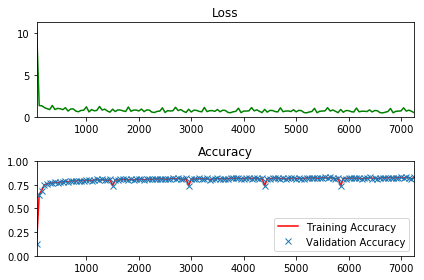

Validation accuracy at 0.8019999861717224


In [33]:
# TODO: Find the best parameters for each configuration
epochs = 5
batch_size = 100 
learning_rate = 0.2



### DON'T MODIFY ANYTHING BELOW ###
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [optimizer, loss],
                feed_dict={features: batch_features, labels: batch_labels})

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)

        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))

## Test
Set the epochs, batch_size, and learning_rate with the best learning parameters you discovered in problem 3.  You're going to test your model against your hold out dataset/testing data.  This will give you a good indicator of how well the model will do in the real world.  You should have a test accuracy of at least 80%.

In [34]:
# TODO: Set the epochs, batch_size, and learning_rate with the best parameters from problem 3
epochs = 5
batch_size = 100
learning_rate = 0.2



### DON'T MODIFY ANYTHING BELOW ###
# The accuracy measured against the test set
test_accuracy = 0.0

with tf.Session() as session:
    
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer
            _ = session.run(optimizer, feed_dict={features: batch_features, labels: batch_labels})

        # Check accuracy against Test data
        test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)


assert test_accuracy >= 0.80, 'Test accuracy at {}, should be equal to or greater than 0.80'.format(test_accuracy)
print('Nice Job! Test Accuracy is {}'.format(test_accuracy))

Epoch  1/5:   0%|          | 0/1425 [00:00<?, ?batches/s]

Epoch  1/5:   4%|▎         | 52/1425 [00:00<00:02, 509.91batches/s]

Epoch  1/5:  11%|█         | 154/1425 [00:00<00:02, 599.74batches/s]

Epoch  1/5:  19%|█▊        | 264/1425 [00:00<00:01, 694.42batches/s]

Epoch  1/5:  24%|██▍       | 339/1425 [00:00<00:01, 709.60batches/s]

Epoch  1/5:  28%|██▊       | 405/1425 [00:00<00:01, 665.32batches/s]

Epoch  1/5:  36%|███▌      | 516/1425 [00:00<00:01, 754.96batches/s]

Epoch  1/5:  44%|████▍     | 627/1425 [00:00<00:00, 835.03batches/s]

Epoch  1/5:  50%|█████     | 715/1425 [00:00<00:00, 792.38batches/s]

Epoch  1/5:  57%|█████▋    | 816/1425 [00:00<00:00, 847.01batches/s]

Epoch  1/5:  65%|██████▌   | 932/1425 [00:01<00:00, 920.02batches/s]

Epoch  1/5:  73%|███████▎  | 1044/1425 [00:01<00:00, 968.88batches/s]

Epoch  1/5:  80%|████████  | 1145/1425 [00:01<00:00, 900.30batches/s]

Epoch  1/5:  87%|████████▋ | 1244/1425 [00:01<00:00, 925.01batches/s]

Epoch  1/5:  95%|█████████▍| 1352/1425 [00:01<00:00, 965.88batches/s]

Epoch  1/5: 100%|██████████| 1425/1425 [00:01<00:00, 906.29batches/s]

Epoch  2/5:   0%|          | 0/1425 [00:00<?, ?batches/s]

Epoch  2/5:   7%|▋         | 97/1425 [00:00<00:01, 967.79batches/s]

Epoch  2/5:  14%|█▍        | 206/1425 [00:00<00:01, 1000.89batches/s]

Epoch  2/5:  22%|██▏       | 311/1425 [00:00<00:01, 1013.30batches/s]

Epoch  2/5:  27%|██▋       | 389/1425 [00:00<00:01, 926.42batches/s] 

Epoch  2/5:  34%|███▍      | 482/1425 [00:00<00:01, 926.30batches/s]

Epoch  2/5:  42%|████▏     | 593/1425 [00:00<00:00, 974.23batches/s]

Epoch  2/5:  49%|████▉     | 704/1425 [00:00<00:00, 1009.21batches/s]

Epoch  2/5:  57%|█████▋    | 815/1425 [00:00<00:00, 1036.72batches/s]

Epoch  2/5:  65%|██████▌   | 929/1425 [00:00<00:00, 1064.96batches/s]

Epoch  2/5:  73%|███████▎  | 1040/1425 [00:01<00:00, 1075.88batches/s]

Epoch  2/5:  81%|████████  | 1150/1425 [00:01<00:00, 1080.71batches/s]

Epoch  2/5:  89%|████████▊ | 1262/1425 [00:01<00:00, 1090.88batches/s]

Epoch  2/5:  96%|█████████▌| 1371/1425 [00:01<00:00, 1026.56batches/s]

Epoch  2/5: 100%|██████████| 1425/1425 [00:01<00:00, 1015.50batches/s]


Epoch  3/5:   0%|          | 0/1425 [00:00<?, ?batches/s]

Epoch  3/5:   8%|▊         | 111/1425 [00:00<00:01, 1109.38batches/s]

Epoch  3/5:  16%|█▌        | 225/1425 [00:00<00:01, 1118.19batches/s]

Epoch  3/5:  21%|██        | 295/1425 [00:00<00:01, 947.36batches/s] 

Epoch  3/5:  28%|██▊       | 399/1425 [00:00<00:01, 970.87batches/s]

Epoch  3/5:  36%|███▌      | 508/1425 [00:00<00:00, 1002.17batches/s]

Epoch  3/5:  44%|████▎     | 620/1425 [00:00<00:00, 1032.53batches/s]

Epoch  3/5:  51%|█████▏    | 732/1425 [00:00<00:00, 1055.08batches/s]

Epoch  3/5:  60%|█████▉    | 850/1425 [00:00<00:00, 1088.64batches/s]

Epoch  3/5:  67%|██████▋   | 954/1425 [00:00<00:00, 1002.03batches/s]

Epoch  3/5:  75%|███████▌  | 1071/1425 [00:01<00:00, 1046.05batches/s]

Epoch  3/5:  83%|████████▎ | 1186/1425 [00:01<00:00, 1075.07batches/s]

Epoch  3/5:  91%|█████████▏| 1301/1425 [00:01<00:00, 1095.09batches/s]

Epoch  3/5:  99%|█████████▉| 1411/1425 [00:01<00:00, 1039.02batches/s]

Epoch  3/5: 100%|██████████| 1425/1425 [00:01<00:00, 1045.30batches/s]


Epoch  4/5:   0%|          | 0/1425 [00:00<?, ?batches/s]

Epoch  4/5:   8%|▊         | 107/1425 [00:00<00:01, 1062.28batches/s]

Epoch  4/5:  14%|█▍        | 198/1425 [00:00<00:01, 1005.85batches/s]

Epoch  4/5:  21%|██        | 295/1425 [00:00<00:01, 994.73batches/s] 

Epoch  4/5:  29%|██▊       | 407/1425 [00:00<00:00, 1027.28batches/s]

Epoch  4/5:  35%|███▍      | 493/1425 [00:00<00:00, 968.21batches/s] 

Epoch  4/5:  42%|████▏     | 596/1425 [00:00<00:00, 984.13batches/s]

Epoch  4/5:  50%|████▉     | 711/1425 [00:00<00:00, 1027.75batches/s]

Epoch  4/5:  57%|█████▋    | 819/1425 [00:00<00:00, 1041.24batches/s]

Epoch  4/5:  64%|██████▍   | 918/1425 [00:00<00:00, 991.70batches/s] 

Epoch  4/5:  72%|███████▏  | 1028/1425 [00:01<00:00, 1020.25batches/s]

Epoch  4/5:  80%|███████▉  | 1138/1425 [00:01<00:00, 1041.55batches/s]

Epoch  4/5:  87%|████████▋ | 1241/1425 [00:01<00:00, 1005.31batches/s]

Epoch  4/5:  95%|█████████▌| 1354/1425 [00:01<00:00, 1039.05batches/s]

Epoch  4/5: 100%|██████████| 1425/1425 [00:01<00:00, 1017.60batches/s]


Epoch  5/5:   0%|          | 0/1425 [00:00<?, ?batches/s]

Epoch  5/5:   6%|▋         | 90/1425 [00:00<00:01, 898.01batches/s]

Epoch  5/5:  12%|█▏        | 164/1425 [00:00<00:01, 843.38batches/s]

Epoch  5/5:  19%|█▊        | 266/1425 [00:00<00:01, 889.17batches/s]

Epoch  5/5:  27%|██▋       | 383/1425 [00:00<00:01, 956.97batches/s]

Epoch  5/5:  35%|███▍      | 496/1425 [00:00<00:00, 1002.60batches/s]

Epoch  5/5:  43%|████▎     | 607/1425 [00:00<00:00, 1029.94batches/s]

Epoch  5/5:  50%|████▉     | 712/1425 [00:00<00:00, 1035.38batches/s]

Epoch  5/5:  57%|█████▋    | 810/1425 [00:00<00:00, 952.06batches/s] 

Epoch  5/5:  65%|██████▍   | 925/1425 [00:00<00:00, 1002.68batches/s]

Epoch  5/5:  73%|███████▎  | 1041/1425 [00:01<00:00, 1042.40batches/s]

Epoch  5/5:  80%|████████  | 1145/1425 [00:01<00:00, 986.97batches/s] 

Epoch  5/5:  87%|████████▋ | 1246/1425 [00:01<00:00, 990.93batches/s]

Epoch  5/5:  95%|█████████▍| 1352/1425 [00:01<00:00, 1009.47batches/s]

Epoch  5/5: 100%|██████████| 1425/1425 [00:01<00:00, 1004.24batches/s]

Nice Job! Test Accuracy is 0.8610000014305115


# Multiple layers
Good job!  You built a one layer TensorFlow network!  However, you want to build more than one layer.  This is deep learning after all!  In the next section, you will start to satisfy your need for more layers.